In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

import xgboost as xgb
from IPython.display import display
from tqdm.auto import tqdm


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load dataset

In [55]:
#@ LOAD AND SETUP THE DATASET:
data = './dataset.csv'
config = {
  'dates': ['Close Approach Date', 'Orbit Determination Date', 'Epoch Date Close Approach'],
  'missing_values': ['n/a', 'na', '--', '-', '?'],
  'replacements': {' ':'_', '(':'_',')':'','.':'' },
  'seed': 666,
}
pd.set_option('display.max_rows', None)
df = pd.read_csv(data, na_values=config['missing_values'], parse_dates=config['dates'])

header = df.columns.str.lower()
for k,v in config['replacements'].items(): header = header.str.replace(k, v)  
df.columns = header

df.head().T

,0,1,2,3,4
neo_reference_id,3703080,3723955,2446862,3092506,3514799
name,3703080,3723955,2446862,3092506,3514799
absolute_magnitude,21.6,21.3,20.3,27.4,21.6
est_dia_in_km_min,0.12722,0.146068,0.231502,0.008801,0.12722
est_dia_in_km_max,0.284472,0.326618,0.517654,0.019681,0.284472
est_dia_in_m_min,127.219879,146.067964,231.502122,8.801465,127.219879
est_dia_in_m_max,284.472297,326.617897,517.654482,19.680675,284.472297
est_dia_in_miles_min,0.079051,0.090762,0.143849,0.005469,0.079051
est_dia_in_miles_max,0.176763,0.202951,0.321655,0.012229,0.176763
est_dia_in_feet_min,417.388066,479.22562,759.521423,28.876199,417.388066


# Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   neo_reference_id              4687 non-null   int64         
 1   name                          4687 non-null   int64         
 2   absolute_magnitude            4687 non-null   float64       
 3   est_dia_in_km_min             4687 non-null   float64       
 4   est_dia_in_km_max             4687 non-null   float64       
 5   est_dia_in_m_min              4687 non-null   float64       
 6   est_dia_in_m_max              4687 non-null   float64       
 7   est_dia_in_miles_min          4687 non-null   float64       
 8   est_dia_in_miles_max          4687 non-null   float64       
 9   est_dia_in_feet_min           4687 non-null   float64       
 10  est_dia_in_feet_max           4687 non-null   float64       
 11  close_approach_date           

In [6]:
df.describe()

,neo_reference_id,name,absolute_magnitude,est_dia_in_km_min,est_dia_in_km_max,est_dia_in_m_min,est_dia_in_m_max,est_dia_in_miles_min,est_dia_in_miles_max,est_dia_in_feet_min,...,semi_major_axis,inclination,asc_node_longitude,orbital_period,perihelion_distance,perihelion_arg,aphelion_dist,perihelion_time,mean_anomaly,mean_motion
count,4.687000e+03,4.687000e+03,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,...,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4.687000e+03,4687.000000,4687.000000
mean,3.272298e+06,3.272298e+06,22.267865,0.204604,0.457509,204.604203,457.508906,0.127135,0.284283,671.273653,...,1.400264,13.373844,172.157275,635.582076,0.813383,183.932151,1.987144,2.457728e+06,181.167927,0.738242
std,5.486011e+05,5.486011e+05,2.890972,0.369573,0.826391,369.573402,826.391249,0.229642,0.513496,1212.511199,...,0.524154,10.936227,103.276777,370.954727,0.242059,103.513035,0.951519,9.442264e+02,107.501623,0.342627
min,2.000433e+06,2.000433e+06,11.160000,0.001011,0.002260,1.010543,2.259644,0.000628,0.001404,3.315431,...,0.615920,0.014513,0.001941,176.557161,0.080744,0.006918,0.803765,2.450100e+06,0.003191,0.086285
25%,3.097594e+06,3.097594e+06,20.100000,0.033462,0.074824,33.462237,74.823838,0.020792,0.046493,109.784247,...,1.000635,4.962341,83.081208,365.605031,0.630834,95.625916,1.266059,2.457815e+06,87.006918,0.453289
50%,3.514799e+06,3.514799e+06,21.900000,0.110804,0.247765,110.803882,247.765013,0.068850,0.153954,363.529809,...,1.240981,10.311836,172.625393,504.947292,0.833153,189.761641,1.618195,2.457973e+06,185.718889,0.712946
75%,3.690060e+06,3.690060e+06,24.500000,0.253837,0.567597,253.837029,567.596853,0.157727,0.352688,832.798679,...,1.678364,19.511681,255.026909,794.195972,0.997227,271.777557,2.451171,2.458108e+06,276.531946,0.984669
max,3.781897e+06,3.781897e+06,32.100000,15.579552,34.836938,15579.552413,34836.938254,9.680682,21.646663,51114.018738,...,5.072008,75.406667,359.905890,4172.231343,1.299832,359.993098,8.983852,2.458839e+06,359.917991,2.039000


In [7]:
#@ Check for na values
df.isna().any()

neo_reference_id                False
name                            False
absolute_magnitude              False
est_dia_in_km_min               False
est_dia_in_km_max               False
est_dia_in_m_min                False
est_dia_in_m_max                False
est_dia_in_miles_min            False
est_dia_in_miles_max            False
est_dia_in_feet_min             False
est_dia_in_feet_max             False
close_approach_date             False
epoch_date_close_approach       False
relative_velocity_km_per_sec    False
relative_velocity_km_per_hr     False
miles_per_hour                  False
miss_dist_astronomical          False
miss_dist_lunar                 False
miss_dist_kilometers            False
miss_dist_miles                 False
orbiting_body                   False
orbit_id                        False
orbit_determination_date        False
orbit_uncertainity              False
minimum_orbit_intersection      False
jupiter_tisserand_invariant     False
epoch_oscula

We are lucky, no need to cleanup from missing values

In [8]:
#@ Check attribute types
df.dtypes

neo_reference_id                         int64
name                                     int64
absolute_magnitude                     float64
est_dia_in_km_min                      float64
est_dia_in_km_max                      float64
est_dia_in_m_min                       float64
est_dia_in_m_max                       float64
est_dia_in_miles_min                   float64
est_dia_in_miles_max                   float64
est_dia_in_feet_min                    float64
est_dia_in_feet_max                    float64
close_approach_date             datetime64[ns]
epoch_date_close_approach               object
relative_velocity_km_per_sec           float64
relative_velocity_km_per_hr            float64
miles_per_hour                         float64
miss_dist_astronomical                 float64
miss_dist_lunar                        float64
miss_dist_kilometers                   float64
miss_dist_miles                        float64
orbiting_body                           object
orbit_id     

In [9]:
#@ Lets drop useless columns: dates + names and ids
for col in ["neo_reference_id","name", "close_approach_date", "epoch_date_close_approach", "orbit_determination_date", "orbit_id"]:
    df.drop(col, axis=1, inplace=True, errors='ignore')

In [10]:
#@ Introspect categorical attributes
categorical = ['equinox', 'orbiting_body']
df[categorical].nunique()

equinox          1
orbiting_body    1
dtype: int64

Given categorical columns contains single value, turned out to be useless, ,less drop them

In [11]:
df.drop('equinox', axis=1, inplace=True, errors='ignore')
df.drop('orbiting_body', axis=1, inplace=True, errors='ignore')

In [12]:
#@ Introspect numerical attributes
numerical = df.select_dtypes(include=[np.number]).columns
df[numerical].isnull().sum()

absolute_magnitude              0
est_dia_in_km_min               0
est_dia_in_km_max               0
est_dia_in_m_min                0
est_dia_in_m_max                0
est_dia_in_miles_min            0
est_dia_in_miles_max            0
est_dia_in_feet_min             0
est_dia_in_feet_max             0
relative_velocity_km_per_sec    0
relative_velocity_km_per_hr     0
miles_per_hour                  0
miss_dist_astronomical          0
miss_dist_lunar                 0
miss_dist_kilometers            0
miss_dist_miles                 0
orbit_uncertainity              0
minimum_orbit_intersection      0
jupiter_tisserand_invariant     0
epoch_osculation                0
eccentricity                    0
semi_major_axis                 0
inclination                     0
asc_node_longitude              0
orbital_period                  0
perihelion_distance             0
perihelion_arg                  0
aphelion_dist                   0
perihelion_time                 0
mean_anomaly  

Seems to be a clean dataset, lucky

# Target

Column `hazardous` is out tagret. If set to true - asteroid should be treated as hazardous.

In [13]:
df.hazardous = df.hazardous.astype('int')
print(df.hazardous.value_counts(normalize=True))

0    0.838916
1    0.161084
Name: hazardous, dtype: float64


# Feature importance analysis

Explore correlation for numerical attributes

In [14]:
corr_matrix = df[numerical].corrwith(df.hazardous).abs().sort_values(ascending=False)
corr_matrix

orbit_uncertainity              0.328721
absolute_magnitude              0.325522
minimum_orbit_intersection      0.288949
perihelion_distance             0.207027
relative_velocity_km_per_sec    0.191970
relative_velocity_km_per_hr     0.191970
miles_per_hour                  0.191970
eccentricity                    0.183269
est_dia_in_miles_max            0.132424
est_dia_in_m_min                0.132424
est_dia_in_feet_max             0.132424
est_dia_in_feet_min             0.132424
est_dia_in_m_max                0.132424
est_dia_in_km_max               0.132424
est_dia_in_km_min               0.132424
est_dia_in_miles_min            0.132424
mean_anomaly                    0.054164
epoch_osculation                0.040940
aphelion_dist                   0.040800
perihelion_time                 0.038113
miss_dist_lunar                 0.032407
miss_dist_kilometers            0.032407
miss_dist_miles                 0.032407
miss_dist_astronomical          0.032407
asc_node_longitu

# Model training

### Validation framework

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=config['seed'])
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=config['seed'])

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.hazardous.values
y_val = df_val.hazardous.values
y_test = df_test.hazardous.values

del df_train['hazardous']
del df_val['hazardous']
del df_test['hazardous']

In [17]:
vectorizer = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
val_dict   = df_val.to_dict(orient='records')
test_dict  = df_test.to_dict(orient='records')

X_train = vectorizer.fit_transform(train_dict)
X_val   = vectorizer.transform(val_dict)
X_test  = vectorizer.transform(test_dict)

### Model 1: Decision Tree

#### Build

In [18]:
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X_train, y_train)

y_pred = tree_classifier.predict_proba(X_val)
y_pred = tree_classifier.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9947023057010415

In [19]:
# print deciscion tree
print(export_text(tree_classifier, feature_names=vectorizer.get_feature_names()))

|--- minimum_orbit_intersection <= 0.05
|   |--- est_dia_in_miles_min <= 0.06
|   |   |--- est_dia_in_miles_max <= 0.14
|   |   |   |--- est_dia_in_feet_max <= 692.05
|   |   |   |   |--- class: 0
|   |   |   |--- est_dia_in_feet_max >  692.05
|   |   |   |   |--- aphelion_dist <= 1.21
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- aphelion_dist >  1.21
|   |   |   |   |   |--- class: 0
|   |   |--- est_dia_in_miles_max >  0.14
|   |   |   |--- inclination <= 2.33
|   |   |   |   |--- class: 1
|   |   |   |--- inclination >  2.33
|   |   |   |   |--- class: 0
|   |--- est_dia_in_miles_min >  0.06
|   |   |--- absolute_magnitude <= 21.98
|   |   |   |--- est_dia_in_feet_max <= 832.03
|   |   |   |   |--- eccentricity <= 0.64
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- eccentricity >  0.64
|   |   |   |   |   |--- aphelion_dist <= 2.51
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- aphelion_dist >  2.51
|   |   |   |   |   |   |--- class: 0
|   |   |   

#### Tune

In [20]:
# Use custom tree depth
tree_classifier_v2 = DecisionTreeClassifier(max_depth=3)
tree_classifier_v2.fit(X_train, y_train)

y_pred = tree_classifier_v2.predict_proba(X_val)[:, 1]
validation_auc = roc_auc_score(y_val, y_pred)

y_pred = tree_classifier_v2.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred)

print(f'validation_roc_auc_score: {validation_auc}')
print(f'test_roc_auc_score: {validation_auc}')
print('tree:')
print(export_text(tree_classifier_v2, feature_names=vectorizer.get_feature_names()))

validation_roc_auc_score: 0.9951280132786364
test_roc_auc_score: 0.9951280132786364
tree:
|--- minimum_orbit_intersection <= 0.05
|   |--- est_dia_in_m_max <= 232.86
|   |   |--- est_dia_in_km_max <= 0.22
|   |   |   |--- class: 0
|   |   |--- est_dia_in_km_max >  0.22
|   |   |   |--- class: 0
|   |--- est_dia_in_m_max >  232.86
|   |   |--- est_dia_in_feet_min <= 350.48
|   |   |   |--- class: 1
|   |   |--- est_dia_in_feet_min >  350.48
|   |   |   |--- class: 1
|--- minimum_orbit_intersection >  0.05
|   |--- class: 0



  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

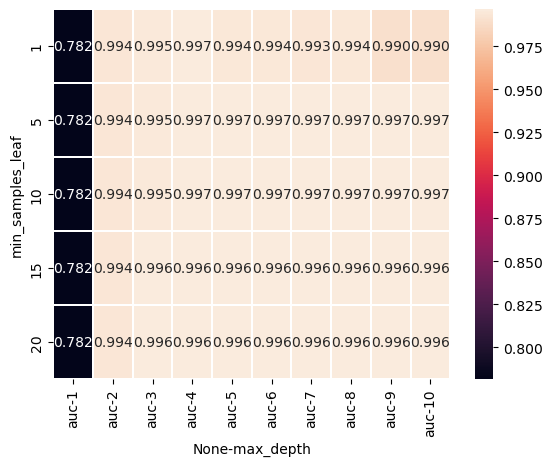

In [21]:
def tune_tree(x_train, y_train, x_val, y_val, max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], min_samples_leaf=[1, 5, 10, 15, 20]):
    scores = []

    for depth in tqdm(max_depth):
        for s in min_samples_leaf:
            tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
            tree.fit(x_train, y_train)

            y_pred = tree.predict_proba(x_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)

            scores.append((depth, s, auc))
    return scores
scores = tune_tree(X_train, y_train, X_val, y_val)

columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f", linewidths=.1)

In [33]:
# Best result
test_classifier = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10)
test_classifier.fit(X_train, y_train)
y_pred = test_classifier.predict_proba(X_val)[:, 1]
print(f'ROC AUC score: {roc_auc_score(y_val, y_pred)}')

ROC AUC score: 0.9965427384607447


#### Cross validation

In [51]:
def train_tree_classifier(x, y, max_depth=4, min_samples_leaf=10):
    vectorizer = DictVectorizer(sparse=False)
    X = vectorizer.fit_transform(x.to_dict(orient='records'))

    tree_classifier = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    tree_classifier.fit(X, y)
    
    return vectorizer, tree_classifier

def predict_tree_classifier(x, vectorizer, tree_classifier):
    X = vectorizer.transform(x.to_dict(orient='records'))
    return tree_classifier.predict_proba(X)[:, 1]

def cross_validation_tree_classifier(df, n_folds=5, shuffle=True, random_state=config['seed']):
    scores = []
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    for t, v in kfold.split(df):
        df_train = df.iloc[t]
        df_validation = df.iloc[v]

        y_train = df_train.hazardous.values
        y_validation = df_validation.hazardous.values

        del df_train['hazardous']
        del df_validation['hazardous']

        vectorizer, model = train_tree_classifier(df_train, y_train)
        y_prediction = predict_tree_classifier(df_validation, vectorizer, model)

        scores.append(roc_auc_score(y_validation, y_prediction))
    
    return scores, np.mean(scores), np.std(scores)

scores, auc_mean, auc_std = cross_validation_tree_classifier(df_full_train)
print(f'Decision Tree Cross Validation:\nauc_scores:\t{scores}\nauc_mean:\t{auc_mean}\nauc_std:\t{auc_std}')


Decision Tree Cross Validation:
auc_scores:	[0.9957650255030697, 0.9999865908603304, 1.0, 0.9999189857009763, 0.9951958376585563]
auc_mean:	0.9981732879445866
auc_std:	0.0022062340423130147


#### Result

In [36]:
vectorizer1, model1 = train_tree_classifier(df_train, y_train, 4, 10)
roc_auc_score(y_val, model1.predict_proba(X_val)[:, 1])

0.9965427384607447

### Model 2: Random Forest

#### Build

In [98]:
classifier_rf = RandomForestClassifier(random_state=config['seed'])
classifier_rf.fit(X_train, y_train)

y_prediction = classifier_rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_prediction)

0.9999827996938346

#### Tune

    n_estimators       auc
7             80  0.999983
8             90  0.999983
9            100  0.999983
11           120  0.999983
12           130  0.999983
13           140  0.999983
14           150  0.999983
15           160  0.999983
16           170  0.999983
18           190  0.999983


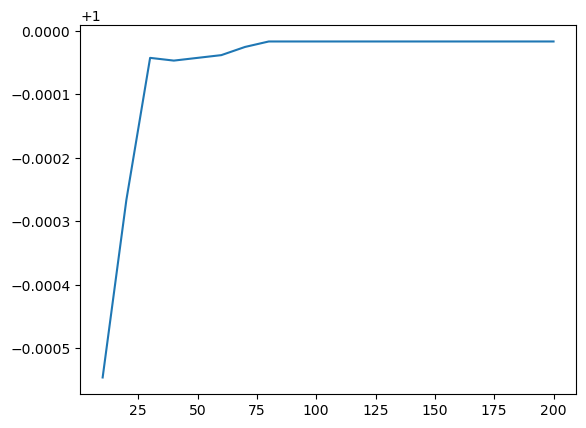

In [25]:
# Tune number of estimators
scores = []

for n in range(10, 201, 10):
    classifier_rf = RandomForestClassifier(n_estimators=n, random_state=config['seed'], n_jobs=-1)
    classifier_rf.fit(X_train, y_train)

    y_prediction = classifier_rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_prediction)
    scores.append((n, auc))
    
classifier_rf_tune_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(classifier_rf_tune_scores.n_estimators, classifier_rf_tune_scores.auc)
print(classifier_rf_tune_scores[classifier_rf_tune_scores.auc == classifier_rf_tune_scores.auc.max()])

In [27]:
classifier_rf = RandomForestClassifier(n_estimators=60, random_state=config['seed'], n_jobs=-1)
classifier_rf.fit(X_train, y_train)
y_prediction = classifier_rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_prediction)

0.9999612993111276

In [28]:
# Tune depth
scores = []

for d in tqdm(range(1, 21, 5)):
    for n in range(10, 201, 20):
        classifier_rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        classifier_rf.fit(X_train, y_train)

        y_prediction = classifier_rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_prediction)

        scores.append((d, n, auc))
        
columns = ['max_depth', 'n_estimators', 'auc']
classifier_rf_tune_scores = pd.DataFrame(scores, columns=columns)
classifier_rf_tune_scores[classifier_rf_tune_scores.auc == classifier_rf_tune_scores.auc.max()]

  0%|          | 0/4 [00:00<?, ?it/s]

,max_depth,n_estimators,auc
23,11,70,0.999983
24,11,90,0.999983


In [30]:
# Fix depth, let's select best n_estimators

scores = []
max_depth = 16

for s in tqdm(range(1, 100, 5)):
    for n in range(10, 201, 20):
        classifier_rf_tune_scores = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=config['seed'], n_jobs=-1)
        classifier_rf_tune_scores.fit(X_train, y_train)
        y_pred = classifier_rf_tune_scores.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

columns = ['min_samples_leaf', 'n_estimators', 'auc']
classifier_rf_tune_scores = pd.DataFrame(scores, columns=columns)
classifier_rf_tune_scores[classifier_rf_tune_scores.auc == classifier_rf_tune_scores.auc.max()]

  0%|          | 0/20 [00:00<?, ?it/s]

,min_samples_leaf,n_estimators,auc
8,1,170,0.999983


### Cross validation

In [50]:
def train_rf_classifier(x, y, n_estimators=70, max_depth=11, min_samples_leaf=1):
    vectorizer = DictVectorizer(sparse=False)
    X = vectorizer.fit_transform(x.to_dict(orient='records'))

    classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=s, random_state=config['seed'], n_jobs=-1)
    classifier.fit(X, y)
    return classifier

def predict_rf_classifier(x, vectorizer, classifier):
    X = vectorizer.transform(x.to_dict(orient='records'))
    return classifier.predict_proba(X)[:, 1]

def cross_validation_rf_classifier(df, n_folds=5, shuffle=True, random_state=config['seed']):
    scores = []
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    for t, v in kfold.split(df):
        df_train = df.iloc[t]
        df_validation = df.iloc[v]

        y_train = df_train.hazardous.values
        y_validation = df_validation.hazardous.values

        del df_train['hazardous']
        del df_validation['hazardous']

        model = train_rf_classifier(df_train, y_train)
        y_prediction = predict_rf_classifier(df_validation, vectorizer, model)

        scores.append(roc_auc_score(y_validation, y_prediction))
    
    return scores, np.mean(scores), np.std(scores)

scores, auc_mean, auc_std = cross_validation_rf_classifier(df_full_train)
print(f'Random Forest Cross Validation:\nauc_scores:\t{scores}\nauc_mean:\t{auc_mean}\nauc_std:\t{auc_std}')


Random Forest Cross Validation:
auc_scores:	[0.9999866824701354, 0.9999865908603305, 0.9923382234726689, 0.9996084308880517, 0.9904676304529457]
auc_mean:	0.9964775116288266
auc_std:	0.004187671205865283


#### Result

In [38]:
model2 = RandomForestClassifier(n_estimators=70, max_depth=11, min_samples_leaf=1, random_state=config['seed'], n_jobs=-1)
model2.fit(X_train, y_train)
roc_auc_score(y_val, model2.predict_proba(X_val)[:, 1])

0.9999827996938346

### Model3: Gradient Boosting model

#### Build

In [46]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

features = vectorizer.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,    
    'objective': 'binary:logistic',
    'seed': config['seed'],
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=15)
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

[13:32:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9951280132786364

## Model selection

In [52]:
# Lets' select random forest model based on roc_auc value